<font size="4">

Notre but est d enlever la brume d une image est de restaurer le plus précisément possible une image réaliste . 
Si on note I(x) le vecteur des coordonnées RGB du pixel x de l'image brumeuse  , alors on a :
I(x)=J(x)t(x) + A(1-t(x)) 

avec J(x) le vecteur des coordonnées RGB du pixel x de l 'image sans brume (l objectif de nos travaux est de trouver cette valeur) , t(x) qui représente la transmission moyenne ,c'est à dire la lumiere qui n'est pas dispersée et qui atteinds l objectif de la caméra , et A la lumière global atmosphérique ( la lumière ambiante naturelle donc provenant du soleil ). 

Notre but sera de déterminer J le plus précisément possible en connaissant I . On va d abord approximer  A ; c est à dire la lumière ambiante de l'image .  

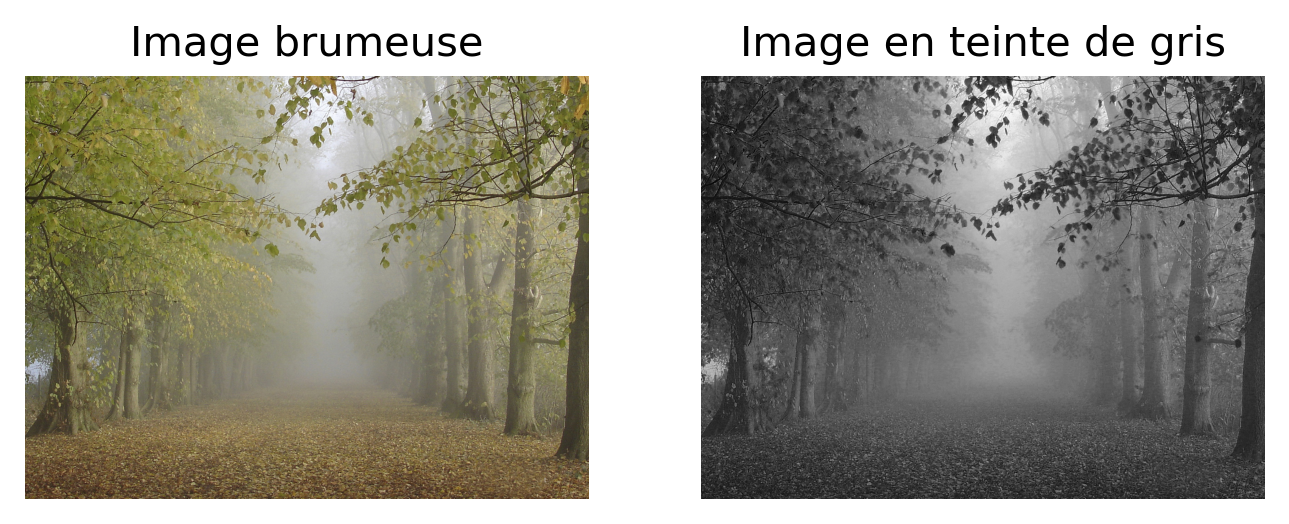

In [275]:
import matplotlib.pyplot as plt 
import numpy as np 
import math  
from PIL import Image
 
t=plt.imread('haze4.jpg')


#pour chaque pixel on affiche le minimum des coordonnées rgb 

dark_channel=np.min(t, axis=2)



plt.figure(dpi=250)
plt.subplot(1,2,1)
plt.title('Image brumeuse')
plt.imshow(t, vmin=0, vmax=1)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Image en teinte de gris')
plt.imshow(dark_channel, cmap='gray')
plt.axis('off')
plt.show()

<font size="4">

On veut déterminer le pixel qui sera une référence pour la lumière ambiante , on veut donc choisir le pixel le plus lumineux 
(celui qui a la moyenne des coordonnées RGB le plus élevée ). Or on ne veut pas avoir un pixel isolé très lumineux qui ne représente pas la lumière (par exemple un pixel qui représente une voiture blanche ) , on va donc utiliser l algorithme du dark channel qui va permettre de différencier les zones lumineuses des simples pixels . Cet algorithme repose sur le principe de prendre tout d abord le minimum dans les coordonnées rgb de chaque pixel , puis de prendre dans une zone donées appelée patch,   la plus petite valeur de pixel . c'est à dire 

$J^{dark}=\min\limits_{y \in \Omega}{(\min\limits_{c \in {r,g,b}}{J^{c}(y)})
}$

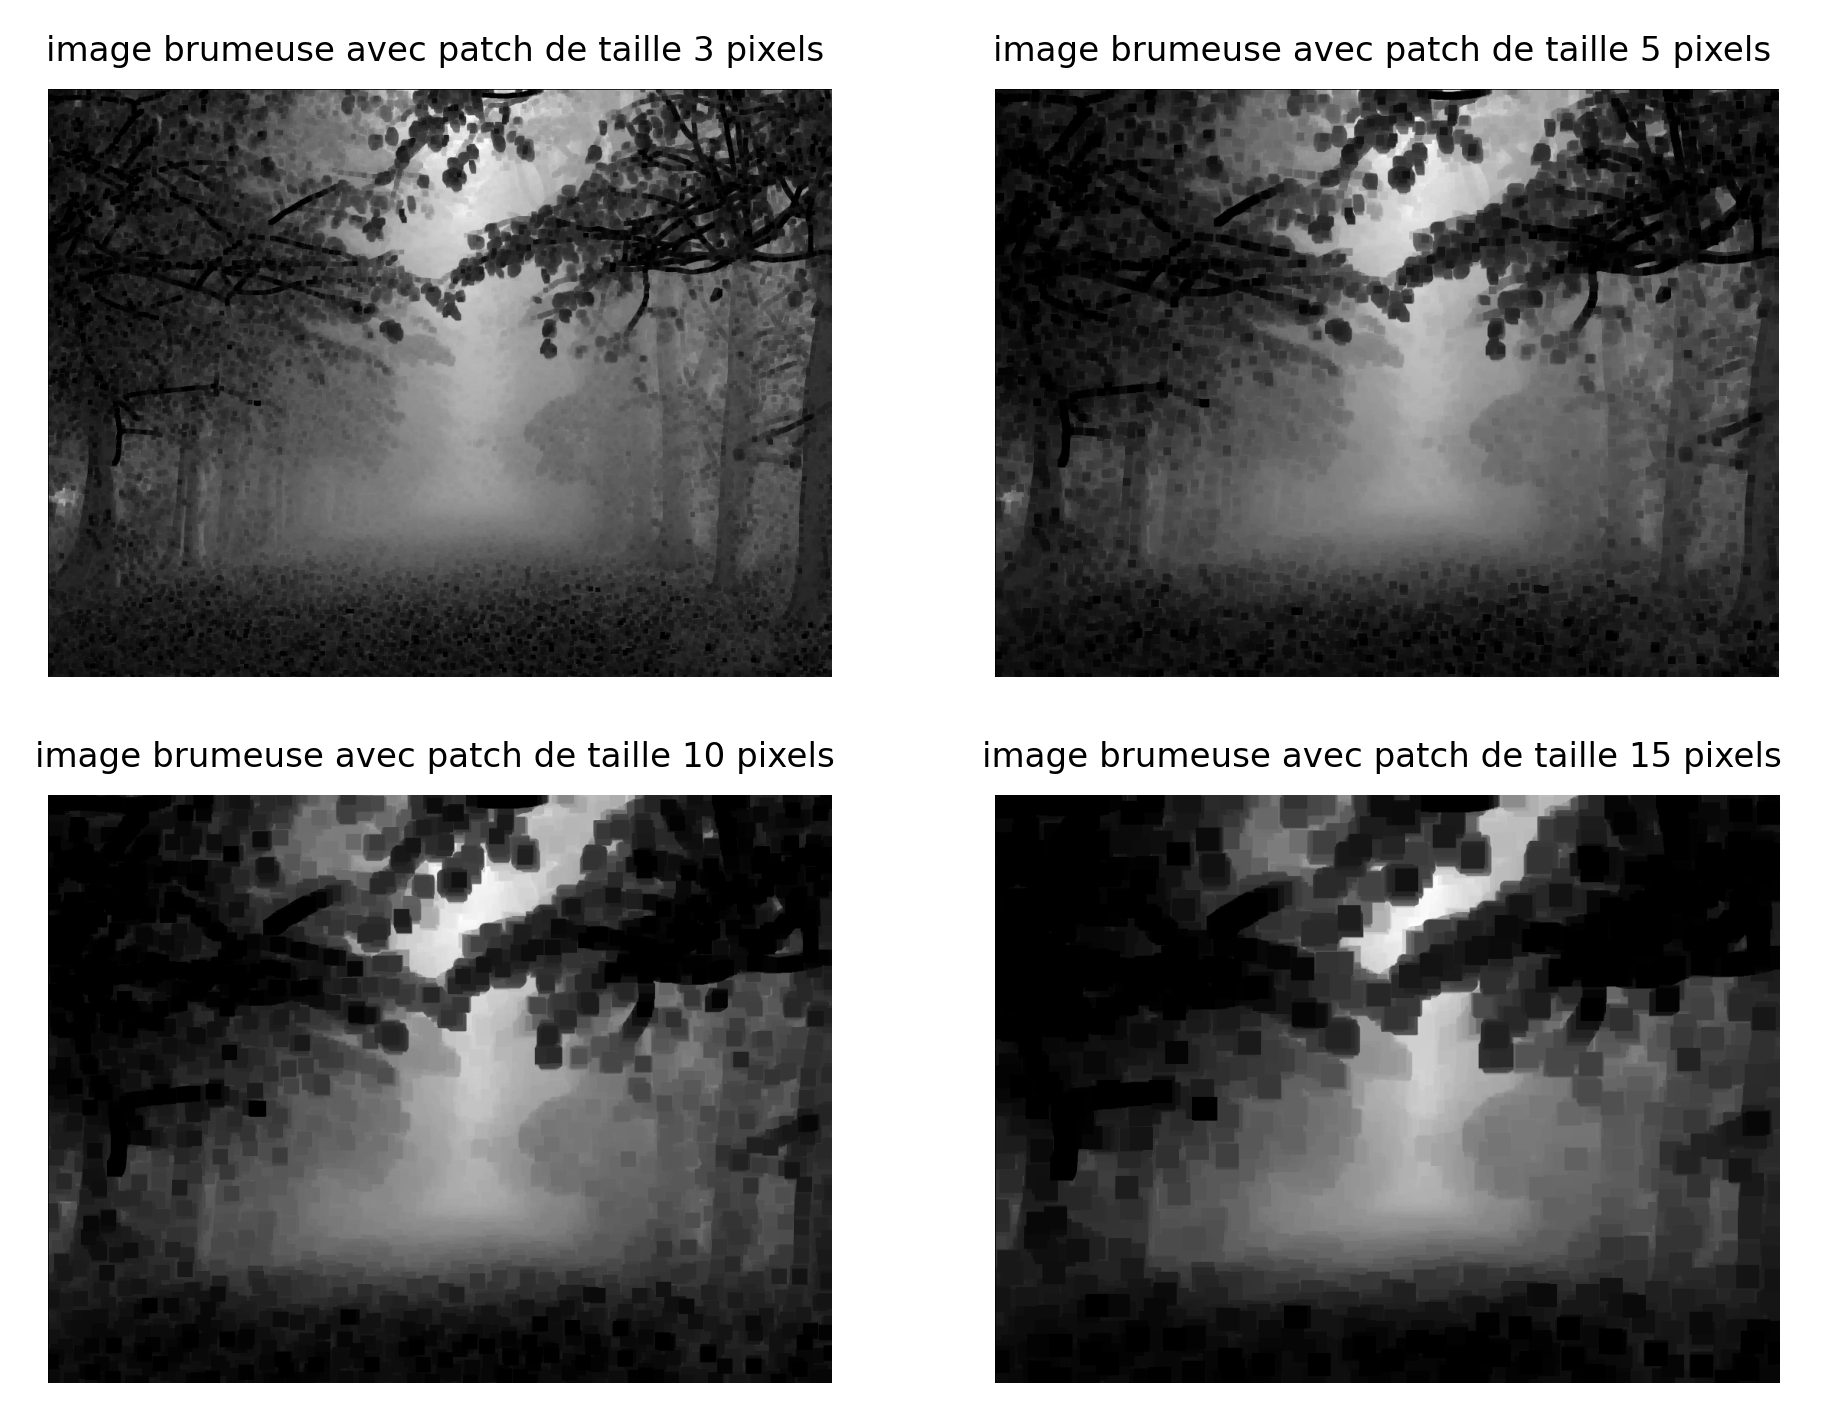

In [276]:
#on applique l algorithme du dark channel  

image=dark_channel
r=0
n,m=np.shape(image)


def darkc (p):
    t1=np.zeros((n,m))
    for i in range (1,n):
        for j in range (1,m):
            patch = image[max(0, i-p):min(n, i+p), max(0, j-p):min(m, j+p)]
            h=np.min(patch)
            t1[i,j]=h
    return t1
          
plt.figure(dpi=350)
plt.subplot(2,2,1)
plt.title('image brumeuse avec patch de taille 3 pixels ' ,fontsize=7)
plt.imshow(darkc(3),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.title('image brumeuse avec patch de taille 5 pixels ' ,fontsize=7)
plt.imshow(darkc(5),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.title('image brumeuse avec patch de taille 10 pixels ' ,fontsize=7)
plt.imshow(darkc(10),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.title('image brumeuse avec patch de taille 15 pixels ' ,fontsize=7)
plt.imshow(darkc(15),cmap='gray')
plt.axis('off')
plt.show()


t1=darkc(3)


            


<font size="4">
Dans la suite des travaux on gardera l'image avec un patch de  pixels . On va alors prélevé les pixels les plus lumineux ( les 10% plus lumineux ) parmi les pixels du dark channel .

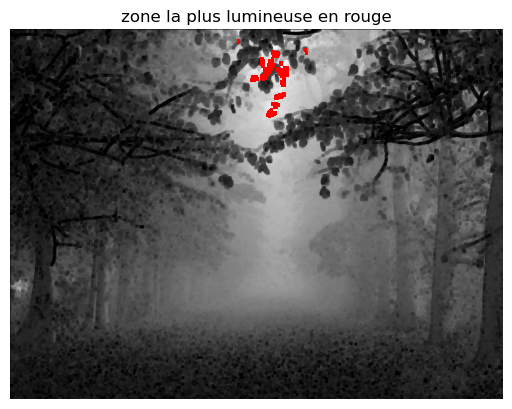

In [277]:
#on affiche les pixels les plus lumineux (approximation de l intensité lumineuse ) en rouge 

t2=t1.flatten()
t2=np.argsort(t2)
k=(0.1/100)*len(t2)
L=t2[len(t2)-int(k):]

t3=t1.copy()
n1,m1=np.shape(t3)    
c=[[i//m1,i%m1] for i in L] #l ensemble des coordonées des pixels lumineux 
a=np.shape(c)[0]
for i in c:
    plt.text(i[1], i[0], '.', color='red', ha='center', va='center', fontsize=20)




plt.subplot(1,1,1)
plt.title('zone la plus lumineuse en rouge')
plt.imshow(t3, cmap='grey')
plt.axis('off')
plt.show()

<font size="4">
    
Ensuite parmi ces pixels on va choisir le pixel le plus lumineux dans l image d origine avec le brume sans dark channel  

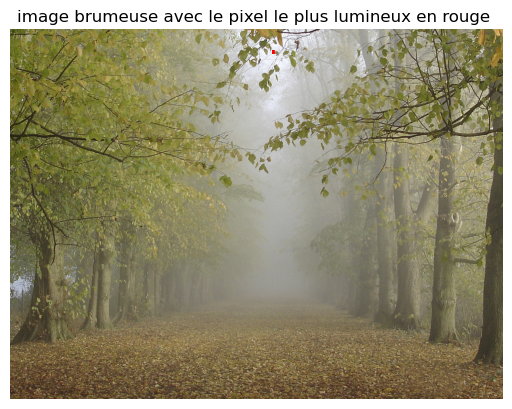

In [287]:
tbis=t.copy()

def intensite(pixel):
    return sum(pixel) / 3

r0=0
for j in c:
    r = intensite(tbis[j[0]][j[1]])
    if r > r0:
        r0 = r
        coord_max=j          
                      
plt.text(coord_max[1], coord_max[0], '.', color='red', ha='center', va='center', fontsize=20)                        
     


plt.subplot(1,1,1)
plt.title('image brumeuse avec le pixel le plus lumineux en rouge ')
plt.imshow(tbis,vmin=0, vmax=1)
plt.axis('off')
plt.show()


<font size="4">
Maintenant qu on a déterminer A la lumiere ambiante on va s'occuper de la transmission t .
Pour estimer la transmission on utilisera la formule :
<font size="6">
    
t(x)=1-$\omega\min\limits_{y \in \Omega}{(\min\limits_{c \in {r,g,b}}{\frac{I^{c}(y)}{A^c}}})$
<font size="4">    
avec $\omega$ un paramêtre qu on fixe à 0.95     
on détermine la matrice des coordonnées rgb divisée par la lumière ambiante A
    


In [279]:


car=np.zeros((n,m,3))

# Remplir chaque élément du tableau avec un tableau de 3 coordonnées
for i in range(n):
    for j in range(m):
        car[i,j,0]=tbis[i,j,0]/A[0]
        car[i,j,1]=tbis[i,j,1]/A[1]
        car[i,j,2]=tbis[i,j,2]/A[2]


<font size="4"> 
Ensuite on applique l algorithme du dark channel a cette nouvelle image dont chaque coordonnées rgb est divisé par la lumière ambiante   

In [280]:
dark_channelbis=np.min(car, axis=2)


image2=dark_channelbis
r=0
n,m=np.shape(image2)
tras=np.zeros((n,m))
p=4
for i in range (1,n):
    for j in range (1,m):
        patch = image2[max(0, i-p):min(n, i+p), max(0, j-p):min(m, j+p)]   
        h=np.min(patch)
        tras[i,j]=h


<font size="4">
Enfin on détermine la transmission t    
    

In [281]:
tras2=np.zeros((n,m))
for i in range (n):
    for j in range (m):
        tras2[i,j]=1-0.95*tras[i,j]
        
tsec=t.copy()
tfinal=np.zeros((n,m,3),dtype=int)   

for i in range(n):
    for j in range (m):
        for k in range (3):
            tfinal[i][j][k]=int((tsec[i][j][k]-int(A[0]))/(max(tras2[i,j],0.1))+int(A[k]))
        
#si la valeur des coordonnées rgb est inférieur a 0 ,on la remet a 0 et si elle est supérieur a 255 on la met a 255           
for i in range(n):
    for j in range (m):
        for k in range (3):
            if tfinal[i][j][k]<0 :
                tfinal[i][j][k]=0
            elif tfinal[i][j][k]>255:
                tfinal[i][j][k]=255
                
                        

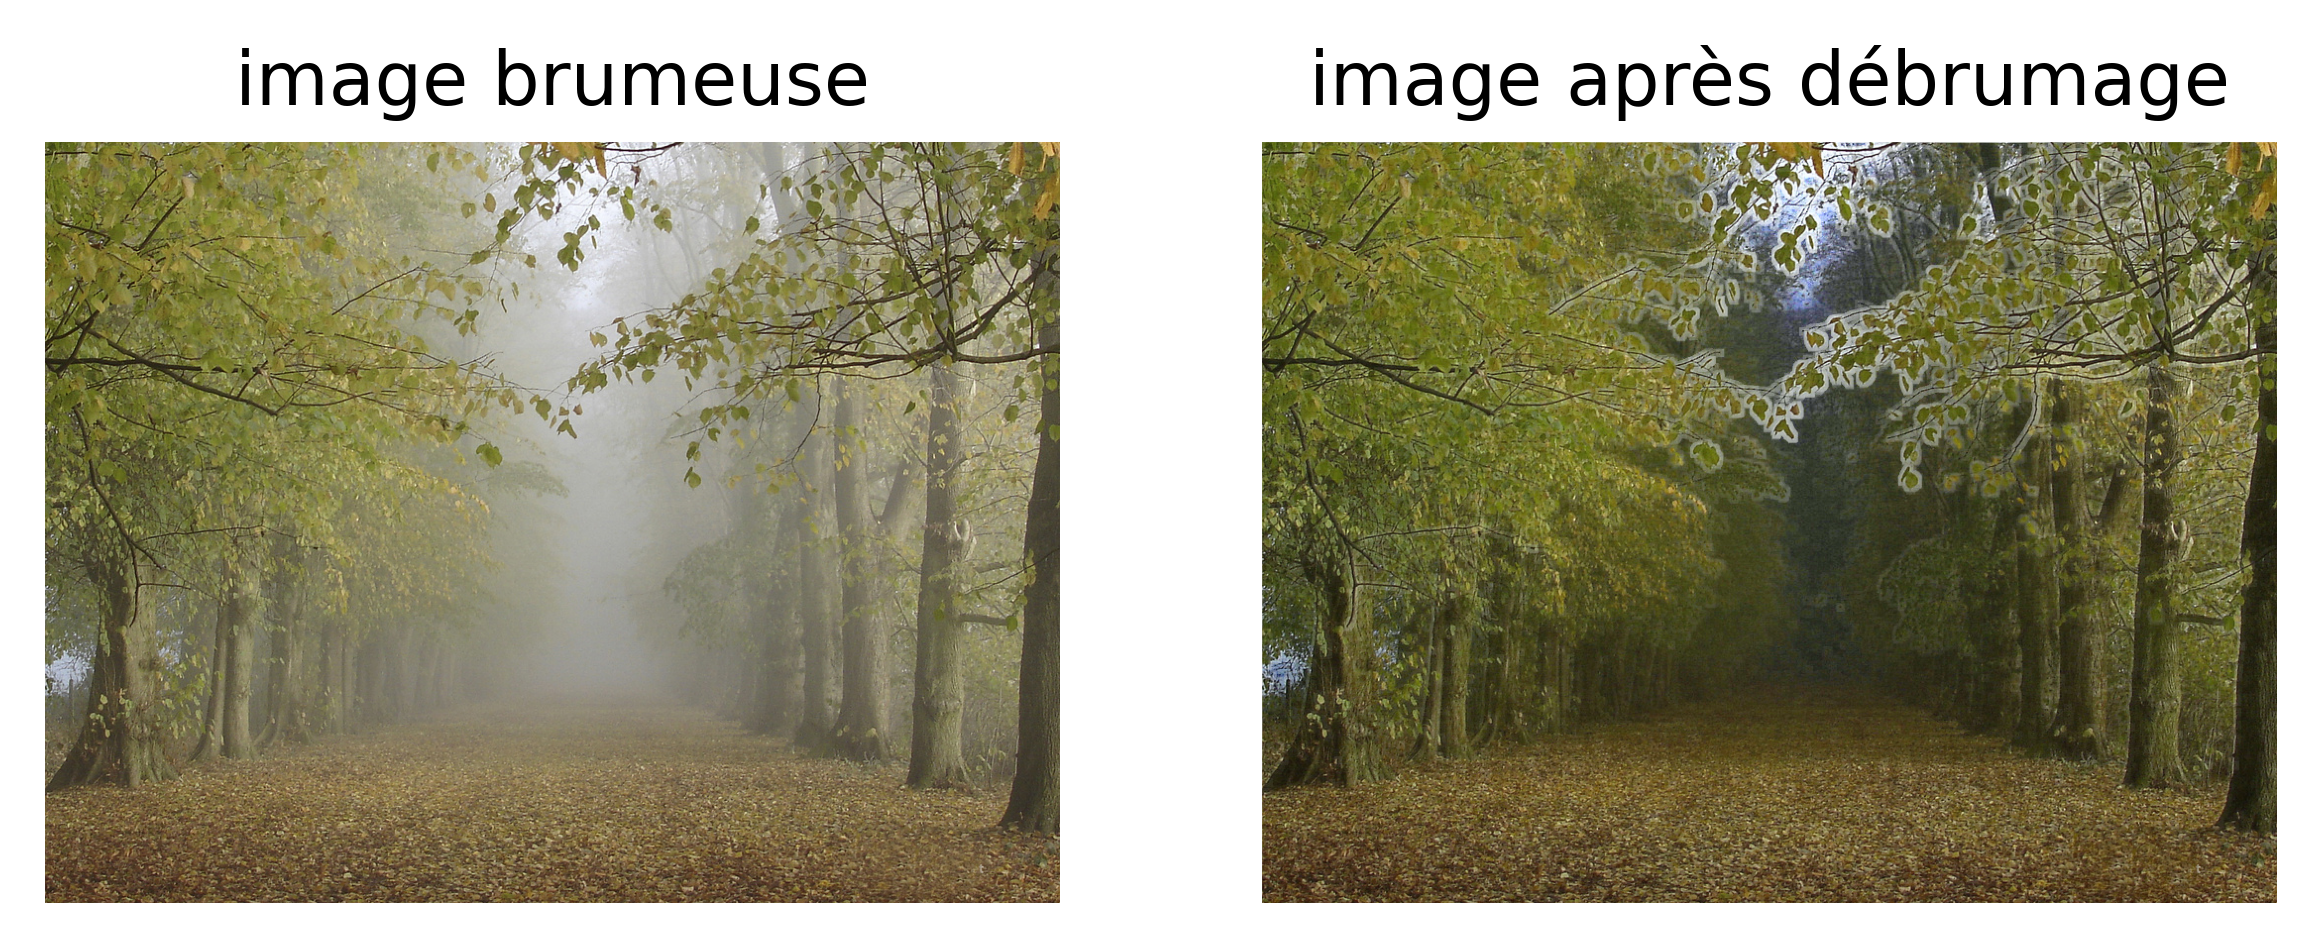

In [282]:
plt.figure(dpi=450)
plt.subplot(1,2,1)
plt.imshow(t)
plt.title('image brumeuse')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('image après débrumage')
plt.imshow(tfinal, cmap='gray')
plt.axis('off')
plt.show()

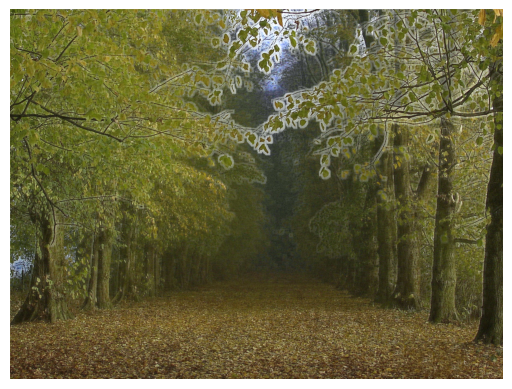

In [283]:
plt.imshow(tfinal, cmap='gray')
plt.axis('off')
plt.show()